# Libraries

In [270]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from sklearn.preprocessing import RobustScaler
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from imblearn.over_sampling import SMOTE
import textstat
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV
import text2emotion as te
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import opinion_lexicon
nltk.download('opinion_lexicon')

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/danielmatuzka/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

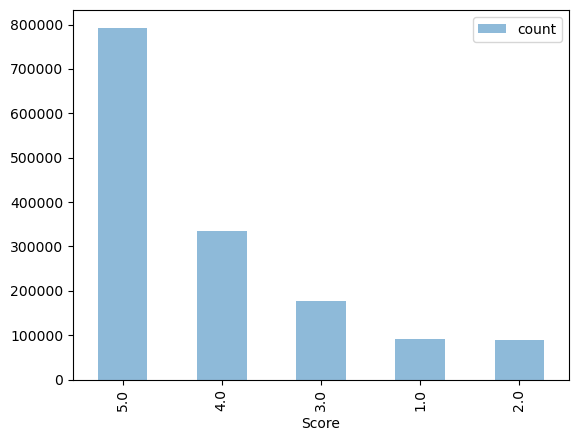


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [272]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Preprocess Text

In [412]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')


# Define a function for text preprocessing
def preprocess_text(text):
    if type(text) == str:
        # Lowercasing
        text = text.lower()

        # Tokenization
        tokens = nltk.word_tokenize(text)

        # Stopword removal
        stop_words = set(stopwords.words("english"))
        filtered_tokens = [word for word in tokens if word not in stop_words]

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

        # Punctuation removal
        punctuation_removed_tokens = [word for word in lemmatized_tokens if word.isalnum()]

        return ' '.join(punctuation_removed_tokens)
        
    else:
        return text


trainingSet['Text'] = trainingSet['Text'].fillna('')
trainingSet['Summary'] = trainingSet['Summary'].fillna('')
trainingSet['CombinedTextSummary'] = trainingSet['Text'] + '' + trainingSet['Summary']
trainingSet['PreprocessedTextSummary'] = trainingSet['CombinedTextSummary'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielmatuzka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/danielmatuzka/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/danielmatuzka/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Adding Features

In [278]:
def add_features_to(df):
    # This is where you can do all your feature extraction
    
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    average_help = df.groupby('ProductId')['Helpfulness'].mean().rename('AverageHelpfulness')

    # Join the average scores with the reviews DataFrame.
    df = df.join(average_help, on='ProductId')

    # Calculate the deviation of each user's score from the product's average score.
    df['Deviation_help'] = df['Helpfulness'] - df['AverageHelpfulness']

    # Now calculate the average deviation for each user and add it as a new column.
    user_average_deviation = df.groupby('UserId')['Deviation_help'].transform('mean').rename('UserAvgDeviation')
    df['Help_devi_user'] = user_average_deviation

    df['ReviewLength'] = df.apply(lambda row : len(row['Text'].split()) if type(row['Text']) == str else 0, axis = 1)

    
    df['Text'] = df['Text'].fillna('')
    df['Summary'] = df['Summary'].fillna('')
    df['CombinedTextSummary'] = df['Text'] + ' ' + df['Summary']
    df['ExclamationCount'] = df['CombinedTextSummary'].str.count('!')
    df['QuestionCount'] = df['CombinedTextSummary'].str.count(r'\?')
    
    negation_words = ['not', 'no', 'never', 'none', "n't", 'neither', 'nor', 'hardly', 'barely', 'scarcely']
    df['NegationCount'] = df['CombinedTextSummary'].apply(lambda x: sum(1 for word in x.split() if word.lower() in negation_words))

    positive_words = set(opinion_lexicon.positive())

    df['PositiveWordCount'] = df['CombinedTextSummary'].apply(lambda text: sum(1 for word in text.split() if word.lower() in positive_words))

    df['Sentiment'] = df['CombinedTextSummary'].apply(lambda x: TextBlob(x).sentiment.polarity)

    # def calculate_text_complexity(text):
    #     fk_grade_level = textstat.flesch_kincaid_grade(text)
    #     gunning_fog = textstat.gunning_fog(text)
    
    #     return fk_grade_level, gunning_fog

    # df["Text_Complexity"] = df["PreprocessedTextSummary"].apply(calculate_text_complexity)

    # df[["Flesch-Kincaid Grade Level", "Gunning Fog Index"]] = pd.DataFrame(df["Text_Complexity"].tolist(), index=df.index)

    df['ProductReviewCount'] = df.groupby('ProductId')['ProductId'].transform('count')
    df['ReviewCountByUser'] = df.groupby('UserId')['UserId'].transform('count')
    

    df.replace([float('inf'), -float('inf')], 0, inplace=True)
    

    # numerical_features = ['HelpfulnessDenominator', 'Helpfulness', 'Sentiment', 'Time',
    #                       'ReviewCountByUser', 'ProductReviewCount', 'ReviewLength', 'Help_devi_user']
    
    # Initialize the RobustScaler
    # scaler = RobustScaler()

    # Apply the scaler to the numerical features and update the DataFrame
    # df[numerical_features] = scaler.fit_transform(df[numerical_features])

    # TF-IDF Vectorization
    tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2), stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['CombinedTextSummary'])
    
    # Convert the TF-IDF matrix to a DataFrame with column names
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f'tfidf_{i}' for i in range(tfidf_matrix.shape[1])])
    tfidf_df.index = df.index  # Align indices with the original DataFrame

    # Concatenate the TF-IDF features with the original DataFrame
    df = pd.concat([df, tfidf_df], axis=1)
    
    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})
    
    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]
    
    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

    

In [215]:
analyzer = SentimentIntensityAnalyzer()

def add_sentiment_scores(df):
    df['Subjectivity'] = df['CombinedTextSummary'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    
    # VADER sentiment
    df['VADER_Compound'] = df['CombinedTextSummary'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    df['VADER_Positive'] = df['CombinedTextSummary'].apply(lambda x: analyzer.polarity_scores(x)['pos'])
    df['VADER_Neutral'] = df['CombinedTextSummary'].apply(lambda x: analyzer.polarity_scores(x)['neu'])
    df['VADER_Negative'] = df['CombinedTextSummary'].apply(lambda x: analyzer.polarity_scores(x)['neg'])
    return df

train = add_sentiment_scores(train)

# Merge on Id so that the submission set can have feature columns as well
X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
X_submission = X_submission.drop(columns=['Score_x'])
X_submission = X_submission.rename(columns={'Score_y': 'Score'})

# The training set is where the score is not null
X_train =  train[train['Score'].notnull()]

X_submission.to_csv("./data/X_submission.csv", index=False)
X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [279]:
# Split training set into training and testing set
# sampled_df = X_train.groupby('Score').apply(lambda x: x.sample(n=150000, random_state=42) if len(x) >= 150000 else x)

# X_train, X_test, Y_train, Y_test = train_test_split(
#     sampled_df.drop(columns=['Score']),
#     sampled_df['Score'],
#     test_size=1/4.0,
#     random_state=0
# )

X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [287]:
# features = ['HelpfulnessDenominator', 'Time', 'Helpfulness', 'Sentiment', 'ReviewCountByUser', 
#             'ProductReviewCount', 'ReviewLength', 'Help_devi_user', 'AverageHelpfulness', 'ExclamationCount',
#            'QuestionCount', 'NegationCount', 'PositiveWordCount']
exclude_columns = ['Score', 'ProductId', 'UserId', 'Summary', 'Text', 'CombinedTextSummary', 'Id', 'AverageHelpfulness', 'UserAvgDeviation']
features = [col for col in X_train.columns if col not in exclude_columns]

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [289]:
# Learn the model
# sm = SMOTE(random_state=42)
# X_resampled, Y_resampled = sm.fit_resample(X_train_select, Y_train)
# model = KNeighborsClassifier(n_neighbors=50).fit(X_train_select, Y_train)
#best
model = HistGradientBoostingClassifier(max_iter=1000, learning_rate=0.05, max_leaf_nodes=80, min_samples_leaf=40, random_state=42)
# model = RandomForestClassifier(n_estimators=100, class_weight=custom_weights, random_state=42)
# brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
# rf = HistGradientBoostingClassifier(max_iter=300, random_state=42)
# model = VotingClassifier(estimators=[
#     ('balanced_rf', brf), ('rf', rf)
# ], voting='hard')
# model.fit(X_train_select, Y_train)

# class HybridEnsemble(BaseEstimator, ClassifierMixin):
#     def __init__(self, model_balanced, model_unbalanced, threshold=0.45):
#         self.model_balanced = model_balanced
#         self.model_unbalanced = model_unbalanced
#         self.threshold = threshold  # Threshold for deciding if class 5 is probable
    
#     def fit(self, X, y):
#         # Fit both models
#         mask = (y != 5)  # Separate data for classes 1-4 and class 5
#         self.model_balanced.fit(X[mask], y[mask])  # Train on classes 1-4
#         self.model_unbalanced.fit(X, y)            # Train on all classes, biased towards 5
#         return self

#     def predict(self, X):
#         # Use probabilities to make final predictions
#         probs = self.predict_proba(X)
#         return np.argmax(probs, axis=1) + 1  # Convert index to class labels (1-5)

#     def predict_proba(self, X):
#         # Get probabilities from each model
#         probs_balanced = self.model_balanced.predict_proba(X)
#         probs_unbalanced = self.model_unbalanced.predict_proba(X)
        
#         # Initialize the final probabilities with balanced model's probabilities
#         final_probs = np.zeros((X.shape[0], 5))
        
#         final_probs[:, :4] = probs_balanced
        
#         # Blend probabilities for each sample based on class 5's probability in the unbalanced model
#         for i in range(len(X)):
#             if probs_unbalanced[i][4] > self.threshold:  # Index `4` corresponds to class 5
#                 final_probs[i] = probs_unbalanced[i]     # Use unbalanced model's probabilities
#             else:
#                 # For classes 1-4, take the probabilities from the balanced model
#                 # For class 5, we just keep it at 0 since it's not predicted by the balanced model
#                 final_probs[i][4] = 0  # Ensure class 5 probability remains 0 if not confident

#         # Normalize each row to ensure they sum to 1 for valid probability distributions
#         final_probs /= final_probs.sum(axis=1, keepdims=True)
        
#         return final_probs

# balanced_model = BalancedRandomForestClassifier(n_estimators=200, random_state=42, sampling_strategy='all', replacement=True, bootstrap=False)
# unbalanced_model = HistGradientBoostingClassifier(max_iter=300, random_state=42)

# model = HybridEnsemble(model_balanced=balanced_model, model_unbalanced=unbalanced_model, threshold=0.45)

# model = HistGradientBoostingRegressor(max_iter=300, random_state=42)
model.fit(X_train_select, Y_train)
# Y_test_continuous = model.predict(X_test_select)

# Y_test_predictions = [
#     1 if score <= 2.4 else 
#     2 if score <= 3 else 
#     3 if score <= 3.4 else 
#     4 if score <= 3.7 else 
#     5 for score in Y_test_continuous
# ]

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)

# Model Evaluation

Accuracy on testing set =  0.6584144817631471


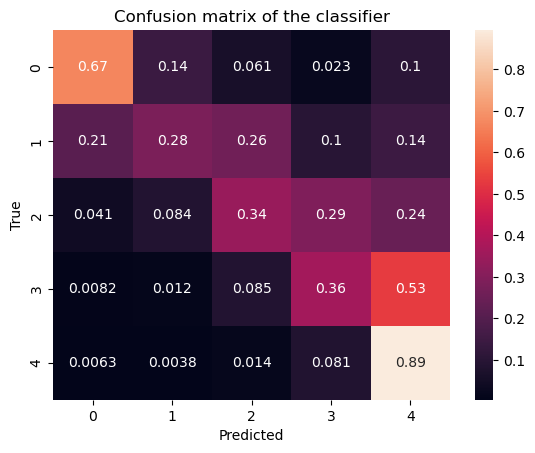

In [290]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [293]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)